In [1]:
# ! pip3 install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics, datasets, linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier

In [2]:
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Noise', 'Incident']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tp, fp, fn, tn = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

In [12]:
def feature_engineering(raw_csv):
    ret = pd.get_dummies(raw_csv, columns=['SITE'])
    ret = ret.drop(['Unnamed: 0', 'POLLER_TIME', 'MEASURED_VALUE', 'NEW_BUS_ID'], axis = 1)
    ret = ret[(ret['LDldDiskTimePercent_VALUE'].isnull()) 
                      & (ret['LDldFreeSpacePct_VALUE'].isnull())
                    & (ret['UsedMBPct_VALUE'].isnull())]
    ret = ret.dropna(how = 'all', axis = 1)
    return ret

In [18]:
week1 = feature_engineering(pd.read_csv("week1.csv"))
week2 = feature_engineering(pd.read_csv("week2.csv"))

# full_data = week1.join(week2)
full_data = week1
full_data

,HAS_NEIGHBOR_INCIDENT,dskPercent_VALUE,utilization_VALUE,PctTotal_VALUE,PctFree_VALUE,used_VALUE,HOUR,WEEKDAY,SITE_MM400MinutemanRd,SITE_REMOTEDCNonNaviSiteCustomerManagedDatacenters,SITE_RHUK01Unit3St,SITE_SCCALafayetteSt,SITE_SYNY01125ElwoodDavisRd,SITE_TOCA1905KingStreetWestCologix,SITE_WOKINGDigitalRealty
10,False,95.0,NaN,NaN,NaN,NaN,7,2,1,0,0,0,0,0,0
11,False,95.0,NaN,NaN,NaN,NaN,7,2,1,0,0,0,0,0,0
12,False,95.0,NaN,NaN,NaN,NaN,7,2,1,0,0,0,0,0,0
13,False,95.0,NaN,NaN,NaN,NaN,7,2,1,0,0,0,0,0,0
14,False,95.0,NaN,NaN,NaN,NaN,7,2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203416,False,NaN,85.75,NaN,NaN,NaN,21,5,0,0,0,1,0,0,0
1203417,False,NaN,NaN,100.44,NaN,NaN,8,3,1,0,0,0,0,0,0
1203418,False,NaN,100.00,NaN,NaN,NaN,22,5,1,0,0,0,0,0,0
1203419,False,NaN,NaN,NaN,11.99,NaN,0,5,1,0,0,0,0,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data[full_data.columns.difference(['HAS_NEIGHBOR_INCIDENT'])], full_data['HAS_NEIGHBOR_INCIDENT'], test_size=0.33)

In [7]:
noise_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
y_train.value_counts()[1]/y_train.value_counts()[0]
# from sklearn.model_selection import GridSearchCV
# param_grid = {'max_depth': [1,3,5], 
#              'min_child_weight': [1,3,5], 
#              'n_estimators': [100,200,500,1000], 
#              }
optimized_GBM = XGBClassifier(n_jobs=8,
                             n_estimators=100, 
                             max_depth=5,
                             min_child_weight=1,
                             reg_alpha = 100,
                             scale_pos_weight=noise_ratio)
optimized_GBM.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=162.40400596633285, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

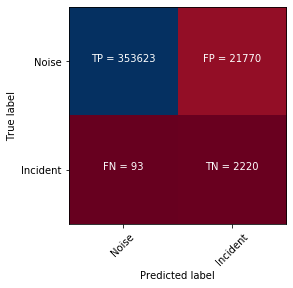

Recall=1.000 
Precision=0.942
F1=0.970


In [8]:
#Make predictions
y_pred = optimized_GBM.predict(X_test)
try:
    scores = optimized_GBM.decision_function(X_test)
except:
    scores = optimized_GBM.predict_proba(X_test)[:,1]
#Make plots
plot_cm(optimized_GBM, y_pred)

In [41]:
def test_on_separate_week(week):
    week_X = week[week.columns.difference(['HAS_NEIGHBOR_INCIDENT'])]
    week_y = week['HAS_NEIGHBOR_INCIDENT']
    week_y_pred = optimized_GBM.predict(week_X)
    result = pd.DataFrame(zip(week_y, week_y_pred), columns=['True','Prediction'])
    TN = len(result.loc[result['Prediction'] & result['True']])
    TP = len(result.loc[~result['Prediction'] & ~result['True']])
    FP = len(result.loc[result['Prediction'] & ~result['True']])
    FN = len(result.loc[~result['Prediction'] & result['True']])
    print (TP,FP)
    print (FN,TN)

In [43]:
test_on_separate_week(week1)
test_on_separate_week(week2)

1071623 65932
201 6805
1065610 69602
3277 3222


Requirement already up-to-date: graphviz in /usr/local/lib/python3.7/site-packages (0.14)


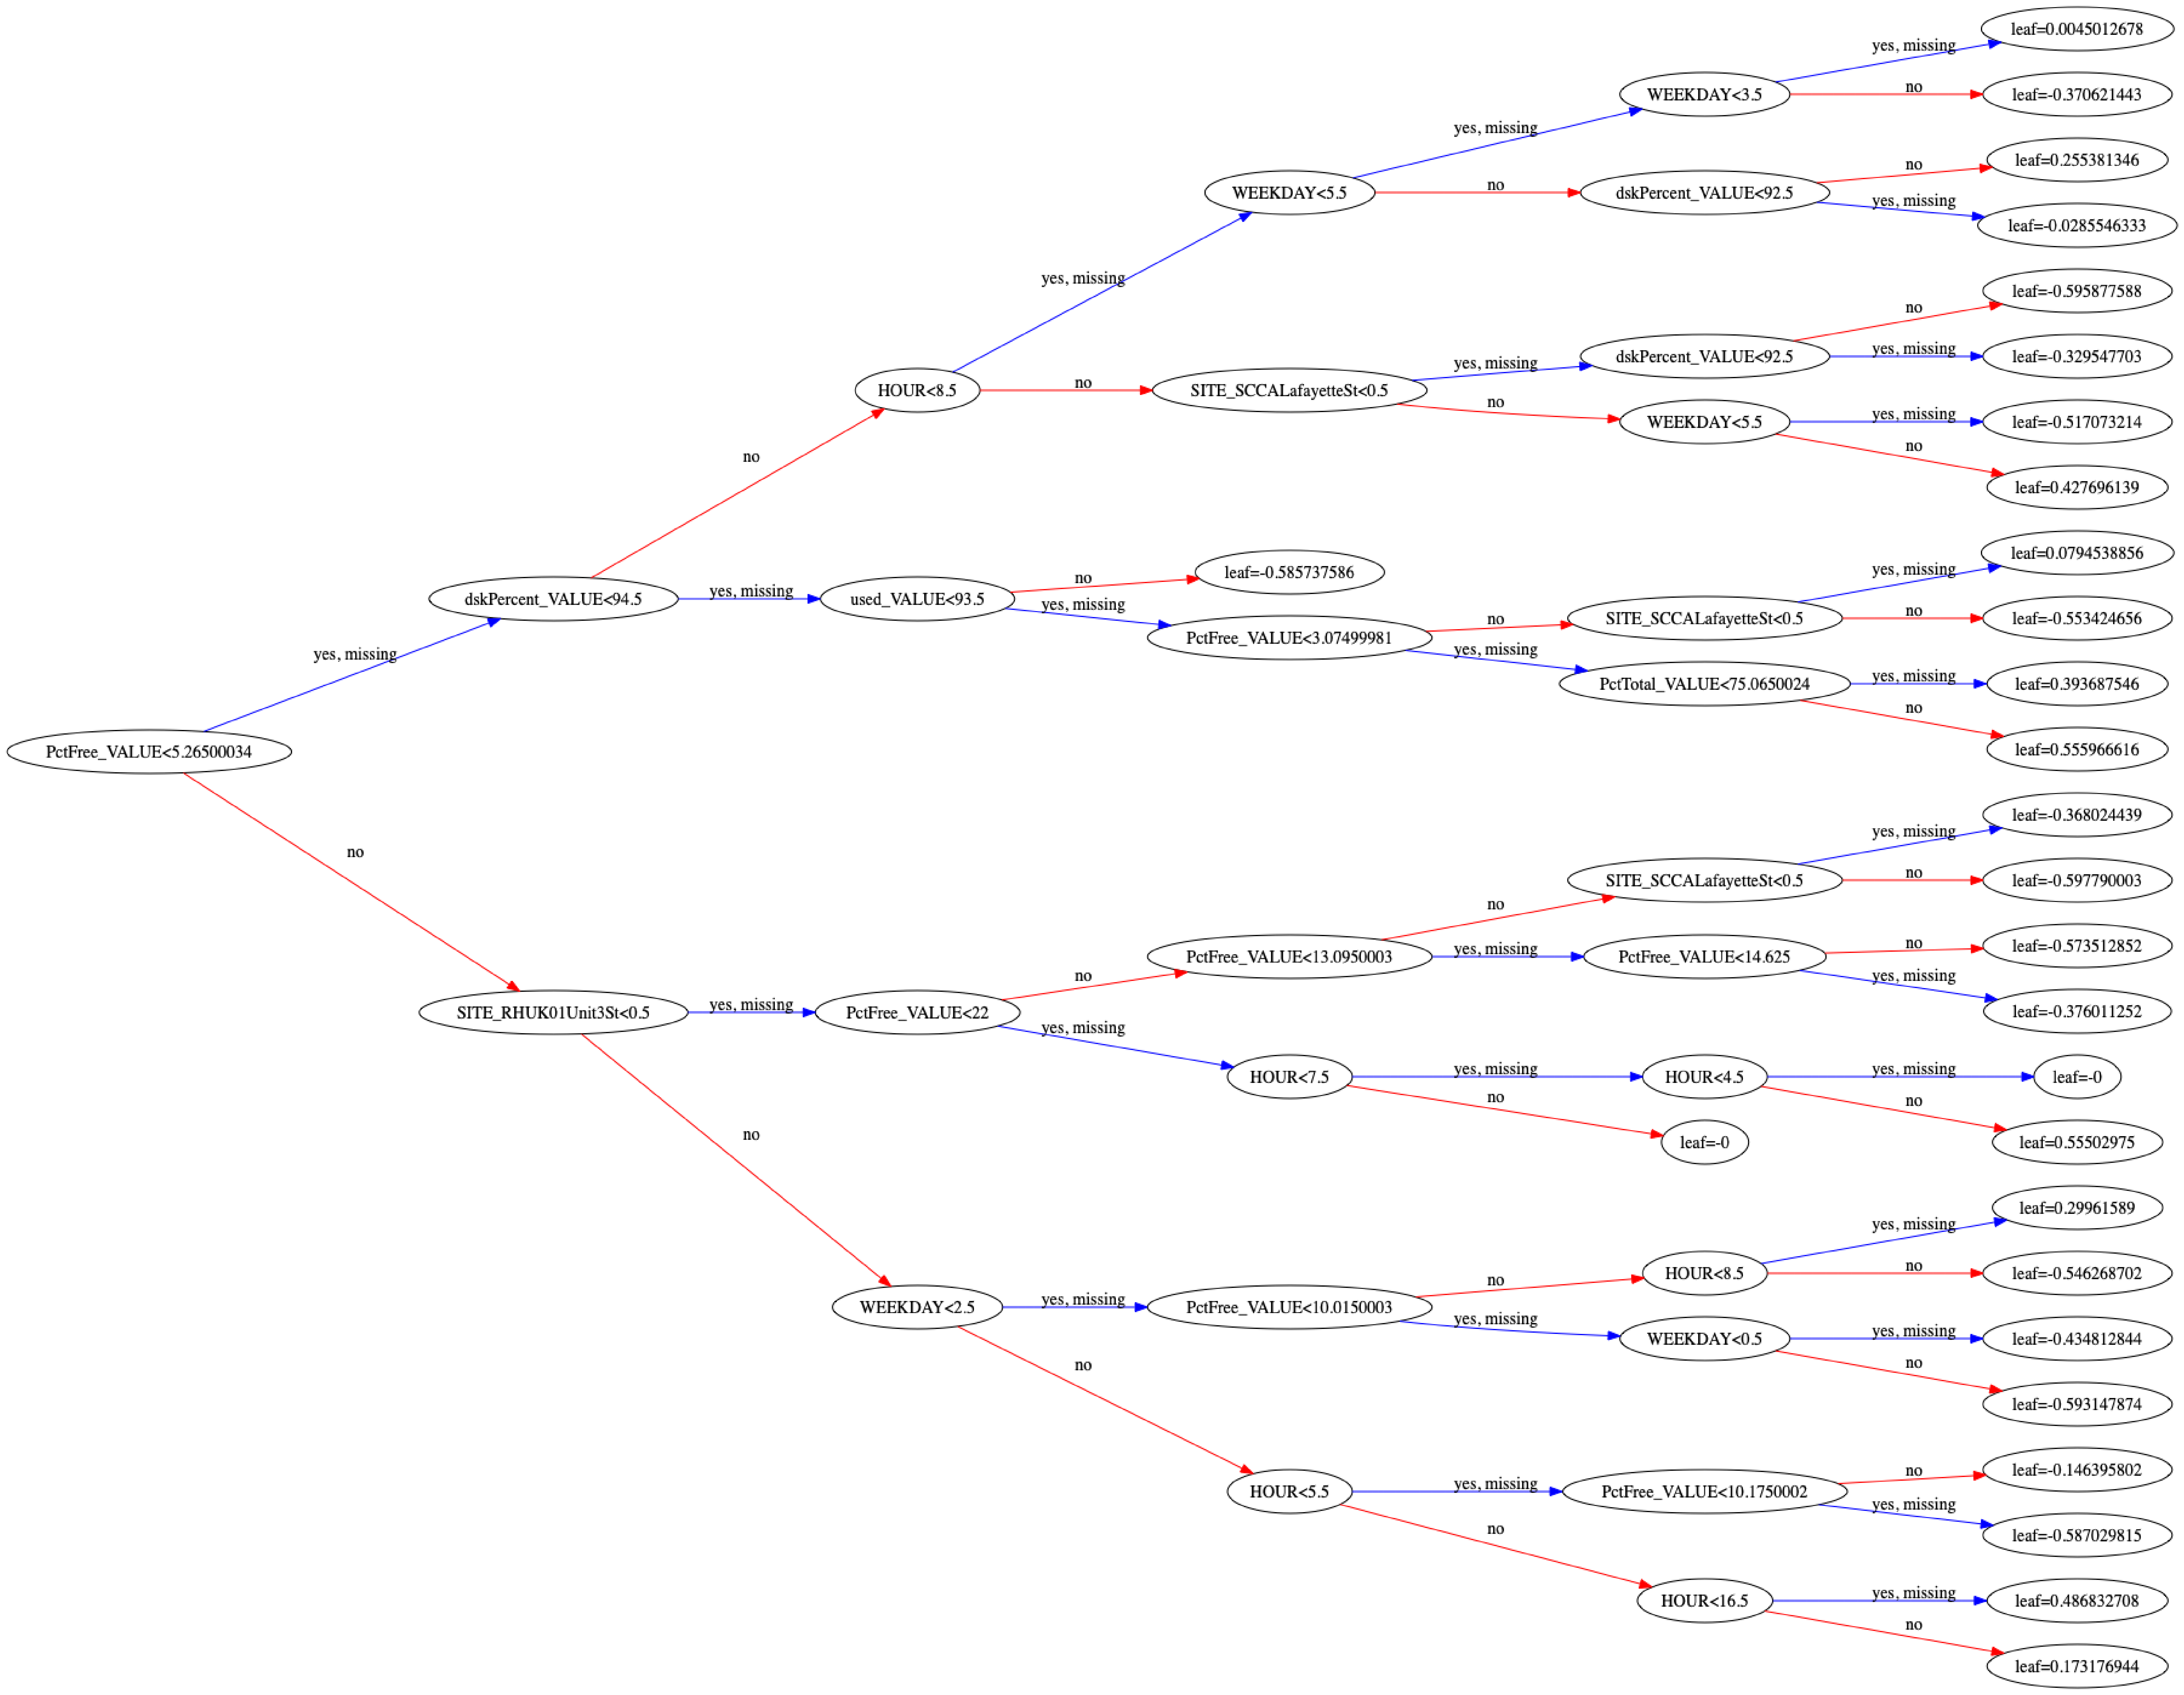

In [44]:
! pip3 install graphviz -U
from xgboost import plot_tree
plot_tree(optimized_GBM, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

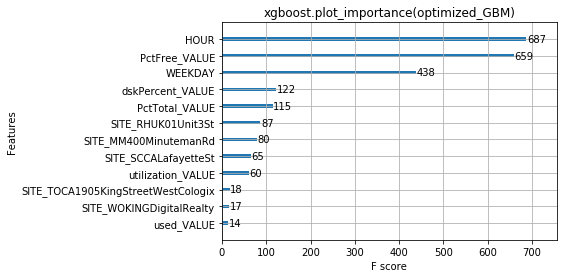

In [45]:
from xgboost import plot_importance
plot_importance(optimized_GBM)
plt.title("xgboost.plot_importance(optimized_GBM)")
plt.show()